# Ejemplo de Autoencoder para replicar un índice

Ejemplo copiado del libro Hands on Deep Learning for Finance

Esta estrategia de inversión pasiva consitente en la inversión en un índice, sin embargo no es posible invertir directamente en un indice sino en la canasta de activos que lo componen.  Esta canasta de activos debe rebalancearse periodicamente según los cambios en el precio de cada activo y los cambios de la importacia de cada acción en el índice.   Lograr replicar un índice usando un número menor de activos, permite minimizar los costos de rebalanceo sin perder los beneficios de la inversión pasiva.

El uso de autoencoders permite reducir la dimensionalidad de los datos conservando la mayor parte de la información.  

## Cargar librerias

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

Using TensorFlow backend.


In [34]:
seed = 0 
np.random.seed(seed)

## Cargar datos

In [35]:
# Load data
stocks_data = pd.read_pickle('data/nasdaq100_6y.pkl')  #datos de acciones de nasdaq
index_data = pd.read_pickle('data/nasdaq100_index_6y.pkl') #datos del indice nasdaq
assets_names = stocks_data.columns.values

data_assets = stocks_data
data_index = index_data

print("Datos de Acciones (series de tiempo) shape: {shape}".format(shape=stocks_data.shape))
print("Datos del Indice (serie de tiempo) shape: {shape}".format(shape=index_data.shape))

stocks_data.head()

Datos de Acciones (series de tiempo) shape: (1510, 98)
Datos del Indice (serie de tiempo) shape: (1510,)


,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AAL,AMGN,...,VRSN,VRSK,VRTX,WBA,WDAY,WDC,WLTW,WYNN,XEL,XLNX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,10.310681,38.340000,2.53,100.050003,28.400000,361.987000,359.288177,257.309998,13.317790,76.250526,...,39.849998,52.786572,43.650002,33.046200,52.910000,36.001884,83.655464,99.407043,21.625166,31.863600
2013-01-03,10.367179,37.750000,2.49,98.480003,29.170000,362.197205,359.496826,258.480011,13.012948,75.771561,...,40.029999,53.394344,45.150002,32.811760,52.299999,35.653797,84.510071,100.476288,21.561975,31.803463
2013-01-04,10.517838,38.130001,2.59,97.620003,29.309999,369.354340,366.600616,259.149994,14.032263,76.105133,...,40.040001,53.304672,45.849998,32.282124,52.189999,35.537758,84.485657,101.688660,21.640961,31.356745
2013-01-07,10.527254,37.939999,2.67,97.309998,28.940001,367.742737,365.001007,268.459991,14.137052,75.720253,...,40.060001,53.065544,47.290001,33.020153,52.169998,35.554348,84.241486,102.033867,21.411921,31.227875
2013-01-08,10.348347,38.139999,2.67,97.489998,28.250000,367.017029,364.280701,266.380005,14.441895,75.395241,...,39.889999,53.703217,48.500000,33.141697,51.869999,34.791882,83.826393,101.949684,21.451403,30.592144


In [36]:
# Split data
n_train = int(data_assets.shape[0]*0.8)  #el elemento correspondiente al 80%

# Stocks data
X_train = data_assets.values[:n_train, :] #se elige el 80% de los datos para train
X_test = data_assets.values[n_train:, :] #los ultimos 20% de datos para test

# Index data
index_train = data_index[:n_train]
index_test = data_index[n_train:]

In [37]:
# Instancia para reescalar los datos
scaler = MinMaxScaler([0, 1])  #  Objeto escalador
# reescalar los datos de las acciones del índice
X_train = scaler.fit_transform(X_train)  #se reescalan los datos train entre 0 y 1 con la libreria de sklearn.
X_test = scaler.fit_transform(X_test)  #se reescalan los datos test entre 0 y 1 con la libreria de sklearn.
# reescalar los datos del índice
scaler_index = MinMaxScaler([0, 1])  
index_train = scaler_index.fit_transform(index_train[:, np.newaxis])
index_test = scaler_index.fit_transform(index_test[:, np.newaxis])

In [38]:
## Autoencoder - Keras

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 50
batch_size = 2

# Define model
input = Input(shape=(n_inputs,))
# Encoder Layers
encoded = Dense(8, input_shape=(n_inputs,), activation='relu')(input)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(n_inputs, activation='sigmoid')(decoded)

# Encoder
encoder = Model(input, encoded)

# Autoencoder
model = Model(input, decoded)

In [39]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 98)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 792       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_8 (Dense)              (None, 98)                882       
Total params: 1,750
Trainable params: 1,750
Non-trainable params: 0
_________________________________________________________________


In [40]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 98)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 792       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
Total params: 828
Trainable params: 828
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile autoencoder
model.compile(loss='mse', optimizer='adam')

In [42]:
# Fit the model
history = model.fit(X_train,
                    X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1
                    )

Epoch 1/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0490
Epoch 2/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0188
Epoch 3/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0141
Epoch 4/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0126
Epoch 5/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0118
Epoch 6/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0112
Epoch 7/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0107
Epoch 8/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0102
Epoch 9/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0097
Epoch 10/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0091
Epoch 11/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0084
Epoch 12/50
1208/1208 [==============================] - 2s 1ms/step - loss: 0.0078
E

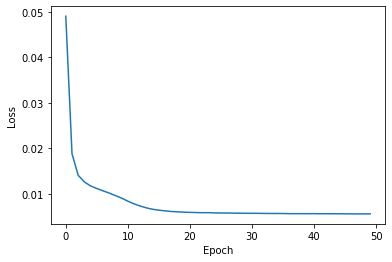

In [43]:
# Visualize loss history
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [44]:
plt.savefig('images/DAE_loss.eps', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [45]:
# Evaluate model
score_train = model.evaluate(X_train, X_train, batch_size=batch_size)
score_test = model.evaluate(X_test, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Test MSE: %.8f' %score_test)

302/302 [==============================] - 0s 545us/step
Training MSE: 0.00564642
Test MSE: 0.09125091


In [46]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

Training MSE: 0.00564642
Testing MSE: 0.09125091


In [47]:
# Sort stocks by reconstruction error
ind = np.argsort(error)
sort_error = error[ind]
sort_assets_names = assets_names[ind]

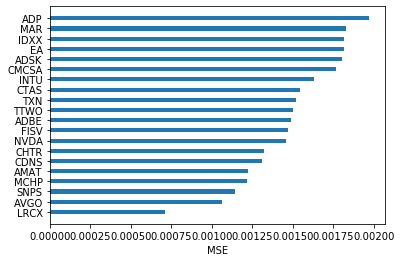

In [48]:
# Barplot
plt.figure()
plt.barh(2*np.arange(len(error[:20])), error[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
plt.show()
#plt.savefig('images/DAE_MSEbar.eps', bbox_inches='tight')

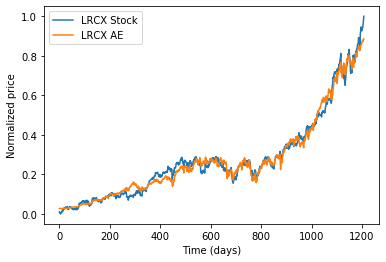

In [49]:
# Plot stock
i=0
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [50]:
# Identify stocks
n = 5

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

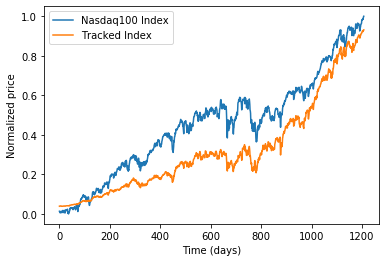

In [51]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [52]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.95339313


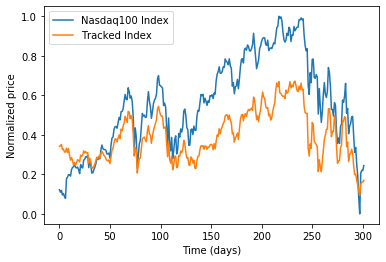

In [53]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [54]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.88595847
